In [13]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [14]:
# loading the dataset
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df


# change label names to its original names
def change_label_names(df, column_name):
    index = {'colon_aca': 'Colon_adenocarcinoma', 'colon_n': 'Colon_benign_tissue'}


    df[column_name] = df[column_name].replace(index)

In [15]:
# loading the data
data_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/colon_image_sets'
df = loading_the_data(data_dir)

change_label_names(df, 'labels')

df

filepaths                labels
0     /kaggle/input/lung-and-colon-cancer-histopatho...  Colon_adenocarcinoma
1     /kaggle/input/lung-and-colon-cancer-histopatho...  Colon_adenocarcinoma
2     /kaggle/input/lung-and-colon-cancer-histopatho...  Colon_adenocarcinoma
3     /kaggle/input/lung-and-colon-cancer-histopatho...  Colon_adenocarcinoma
4     /kaggle/input/lung-and-colon-cancer-histopatho...  Colon_adenocarcinoma
...                                                 ...                   ...
9995  /kaggle/input/lung-and-colon-cancer-histopatho...   Colon_benign_tissue
9996  /kaggle/input/lung-and-colon-cancer-histopatho...   Colon_benign_tissue
9997  /kaggle/input/lung-and-colon-cancer-histopatho...   Colon_benign_tissue
9998  /kaggle/input/lung-and-colon-cancer-histopatho...   Colon_benign_tissue
9999  /kaggle/input/lung-and-colon-cancer-histopatho...   Colon_benign_tissue

[10000 rows x 2 columns]

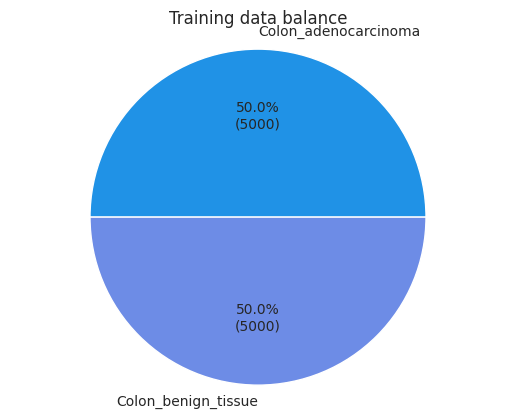

In [16]:
data_balance = df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

In [17]:
# Check for GPU availability
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT available")

# Set TensorFlow to use the GPU device
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
    print("GPU device configured")
else:
    print("No GPU device found")

GPU is available
GPU device configured


In [18]:
# Generate data paths with labels
data_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)

    for f in flist:
        f_path = os.path.join(foldpath, f)
        filelist = os.listdir(f_path)

        for file in filelist:
            fpath = os.path.join(f_path, file)
            filepaths.append(fpath)

            if f == 'colon_aca':
                labels.append('Colon Adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung Adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [19]:
df

filepaths                labels
0      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
1      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
2      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
3      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
4      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
...                                                  ...                   ...
24995  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24996  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24997  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24998  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24999  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue

[25000 rows x 2 columns]

In [20]:
strat = df['labels']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [21]:
# crobed image size
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


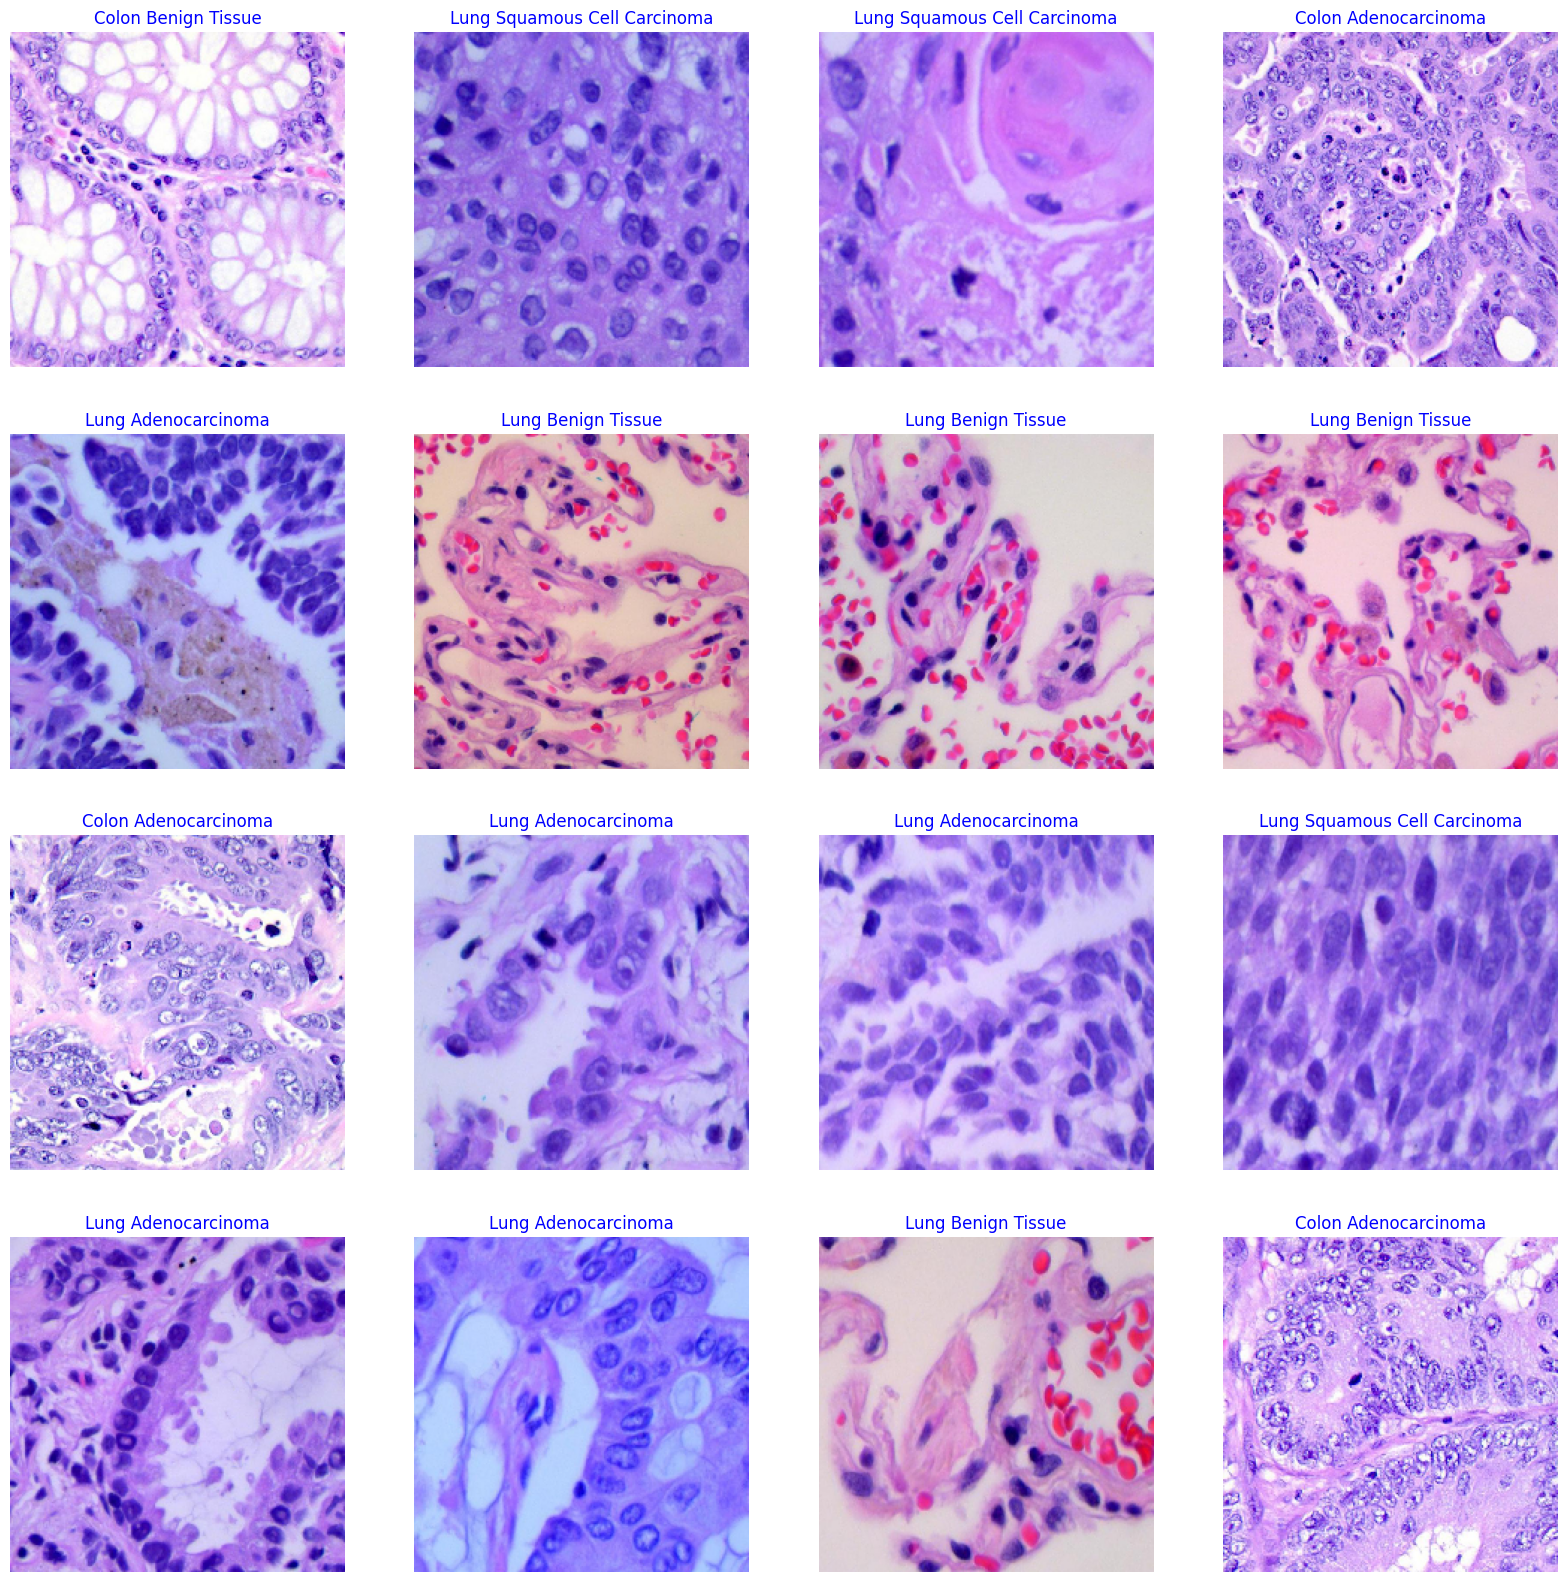

In [22]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [23]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [27]:
epochs = 25   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 132s 421ms/step - accuracy: 0.9922 - loss: 0.0248 - val_accuracy: 0.9784 - val_loss: 0.1401
Epoch 2/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 131s 417ms/step - accuracy: 0.9906 - loss: 0.0289 - val_accuracy: 0.9820 - val_loss: 0.0710
Epoch 3/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 131s 419ms/step - accuracy: 0.9928 - loss: 0.0199 - val_accuracy: 0.9252 - val_loss: 0.3931
Epoch 4/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 130s 415ms/step - accuracy: 0.9944 - loss: 0.0188 - val_accuracy: 0.9812 - val_loss: 0.0751
Epoch 5/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 131s 418ms/step - accuracy: 0.9941 - loss: 0.0193 - val_accuracy: 0.9752 - val_loss: 0.1149
Epoch 6/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 131s 418ms/step - accuracy: 0.9941 - loss: 0.0212 - val_accuracy: 0.9824 - val_loss: 0.0755
Epoch 7/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 131s 417ms/step - accuracy: 0.9929 - loss: 0.0203 - val_accuracy: 0.9756 - val_loss: 0.1128
Epoch 8/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 131s 417ms/step - accuracy: 0.9925 -

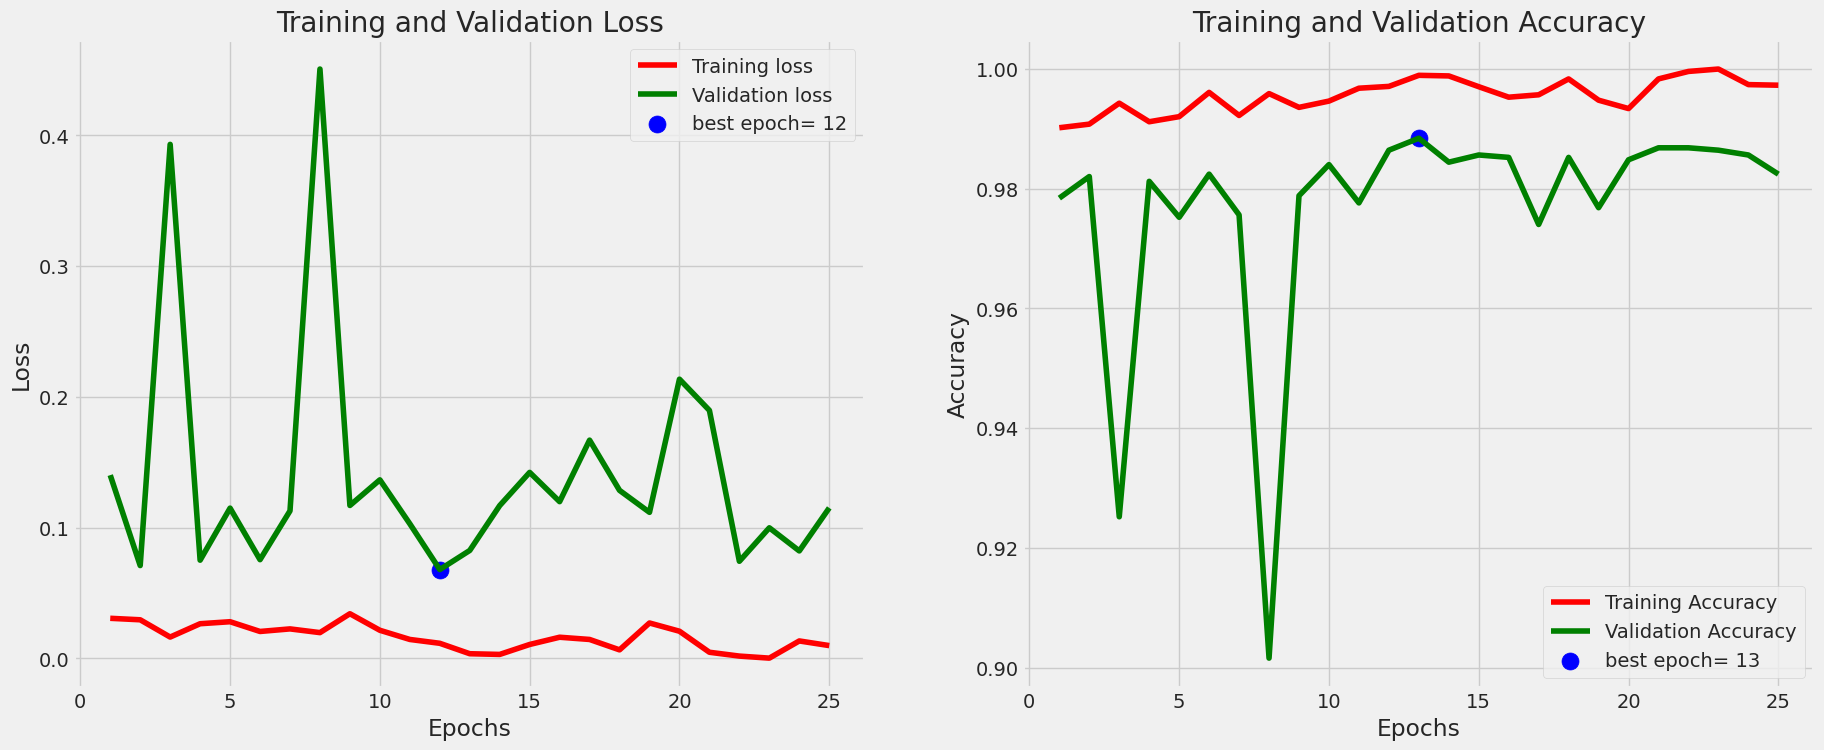

In [28]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [29]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 318ms/step - accuracy: 0.9993 - loss: 0.0024
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 308ms/step - accuracy: 0.9806 - loss: 0.0813
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 260ms/step - accuracy: 0.9824 - loss: 0.0980
Train Loss:  0.0031030827667564154
Train Accuracy:  0.9990624785423279
--------------------
Valid Loss:  0.11889245361089706
Valid Accuracy:  0.9815999865531921
--------------------
Test Loss:  0.11507593095302582
Test Accuracy:  0.9824000000953674
